In [0]:
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from time import time
import os
import functools
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.python.ops import array_ops
from skimage.transform import resize
model_save_interval = 1


Using TensorFlow backend.


 **for resist GPU memory**
 
 
**NOTE:FID GENERATION WILL TAKE TIME AS WE CONSIDER 10,000 images**

In [0]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

**Mount the Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**load cifar10 dataset**

In [0]:

# load cifar10 dataset
from keras.datasets import cifar100, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**directeries**

In [0]:
# directeries
SAVE_IMG_DIR = '/content/drive/My Drive/DeepProjects4/img'
SAVE_LOGS_DIR = '/content/drive/My Drive/DeepProjects4/loss'
SAVE_LOSS_FID_LOGS = '/content/drive/My Drive/DeepProjects4/fid_loss'
model_save_dir = '/content/drive/My Drive/DeepProjects4/model'

**#checking shape**

In [0]:
#checking shape
X = x_train
X.shape

(50000, 32, 32, 3)

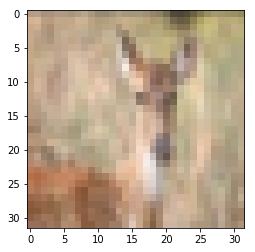

In [0]:
plt.imshow(X[14000])

**Declaring Parameters**

In [0]:


BATCHSIZE=64
#Hyperperemeter
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
#Momentum
BETA_1 = 0.0
BETA_2 = 0.9
# No of epochs
EPOCHS = 500
#Batch NOrmalization Parameters
BN_M = 0.1
BN_E  = 0.00002
GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

#Generate FID for every 1000 steps
FID_AT = 1000

**GENERATOR**

In [0]:
#GENERATOR
def BuildGenerator():
    model = Sequential()
    
    model.add(Dense(4*4*512, kernel_initializer='glorot_uniform' , input_dim=128))
    model.add(Reshape((4,4,512)))
    
    
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_E, momentum=BN_M))
    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_E, momentum=BN_M))
    
    model.add(Conv2DTranspose(64,  kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_E, momentum=BN_M))
    # Final CNN layer         
    model.add(Conv2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh'))
    model.summary()
    return model

**DISCRIMINATOR**

In [0]:
#DISCRIMINATOR
def BuildDiscriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same', input_shape=(32,32,3) ))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    #classifier
    model.add(Dense(1,kernel_initializer='glorot_uniform'))
    model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform'))
    
    model.summary()
    return model

**Build generater && discrminator**

In [0]:
#Build generater
generator = BuildGenerator()

#Build discriminator
discriminator = BuildDiscriminator()










Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 6

**loading weights to generator and discriminator**

In [0]:
 # loading weights to generator and discriminator
  # build the model before this step
  discriminator.load_weights('/content/drive/My Drive/DeepProjects2/modeldiscriminator_model_weights_130.h5')
  generator.load_weights('/content/drive/My Drive/DeepProjects2/modelgenerator_model_weights_130.h5')

**Compling the Generator**

In [0]:
#Fake input for generator
Noise_input                        = Input(shape=(128,))
#Calling Generator
Generated_image                    = generator(Noise_input)
#Calling Discrminator
Discriminator_output               = discriminator(Generated_image)
training_generator                 = Model(Noise_input, Discriminator_output)
print("model_for_training_generator")
discriminator.trainable = False
generator.trainable = True
#compling the model
training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss='binary_crossentropy')
training_generator.summary()

model_for_training_generator


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         3813251   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2935875   
Total params: 6,749,126
Trainable params: 3,812,355
Non-trainable params: 2,936,771
_________________________________________________________________


**compling Discriminator**

In [0]:
image_input                             = Input(shape=(32,32,3))
Discriminator_output                    = discriminator(image_input)

training_discriminator                  = Model(image_input, Discriminator_output)
print("model_for_training_discriminator")
discriminator.trainable = True
#compling discrimator
training_discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss='binary_crossentropy')
training_discriminator.summary()

model_for_training_discriminator
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2935875   
Total params: 2,935,875
Trainable params: 2,935,875
Non-trainable params: 0
_________________________________________________________________


**Create fake and real Labels**

In [0]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = np.zeros((BATCHSIZE, 1), dtype=np.float32)

**Check Point**

In [0]:
X = X/255*2-1

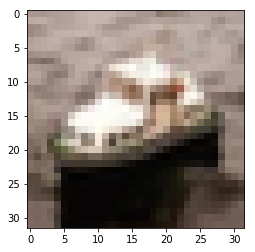

In [0]:
plt.imshow((X[8787]+1)/2)

**funtion to scale Images**

In [0]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

**Function to save models**

In [0]:
logs_loss = open(SAVE_LOGS_DIR + "logs_" + str(18) + ".txt", 'w')

def save_models(generator, discriminator, gan, epoch_no, model_save_dir = model_save_dir):
        discriminator.trainable = True
        save_model(discriminator, model_save_dir + 'discriminator_model', epoch_no)
        generator.trainable = True
        save_model(generator, model_save_dir + 'generator_model', epoch_no)
        discriminator.trainable = False
        save_model(gan, model_save_dir + 'gan_model', epoch_no)
        
def save_model(model, model_path, epoch_no):
        with open(str(model_path) + '_' + str(epoch_no) + '.json', 'w') as json_file:
            json_file.write(model.to_json())

        with open(str(model_path) + '.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        model.save_weights(str(model_path + '_' + "weights_" + str(epoch_no) + '.h5'))
        model.save_weights(str(model_path + '_' + "weights" + '.h5'))
        
        model.save(str(model_path+ '.h5'))  # creates a HDF5 file 'my_model.h5'
        
        
def log_write(file, data):
    for values in data:
        file.write(str(values) + '\t')
    file.write('\n')

**Function to Generate FID**

In [0]:
#loading Inception
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
# mean1 and sigma1 for Xtest
np.random.shuffle(x_test)
n_batches = int(np.ceil(float(x_test.shape[0]) / BATCHSIZE))
act = np.zeros([x_test.shape[0], 2048], dtype = np.float32)
for i in range(n_batches):
  inp = x_test[i * BATCHSIZE : (i + 1) * BATCHSIZE]
  size = 299
  inp = inp.astype('float32')
  inp = scale_images(inp, (299,299,3))
  inp = preprocess_input(inp)
  activations = inception.predict(inp)
  act[i * BATCHSIZE : i * BATCHSIZE + min(BATCHSIZE, inp.shape[0])] = activations
f1 = act
mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)


def generateFID():
      samples = np.zeros((10000, 32, 32, 3))
      noOf_batches = 20
      n = 0
      for btch in range(noOf_batches):
          sample_fid = np.random.randn(500, 128)
          samples[n:(n+500)] = generator.predict(sample_fid)
          n += 500

      samples = (samples + 1.) * 127.5

     
      #Generate Activations
      n_batches = int(np.ceil(float(samples.shape[0]) / BATCHSIZE))
      act = np.zeros([samples.shape[0], 2048], dtype = np.float32)
      for i in range(n_batches):
        inp = samples[i * BATCHSIZE : (i + 1) * BATCHSIZE]
        size = 299
        inp = inp.astype('float32')
        inp = scale_images(inp, (299,299,3))
        inp = preprocess_input(inp)
        activations = inception.predict(inp)
        act[i * BATCHSIZE : i * BATCHSIZE + min(BATCHSIZE, inp.shape[0])] = activations
      f2 = act
      mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
      sum_sq_diff = np.sum((mean1 - mean2)**2)
      cov_mean = sqrtm(sigma1.dot(sigma2))
      if np.iscomplexobj(cov_mean):
          cov_mean = cov_mean.real
      fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
      
      return fid



87916544/87910968 [==============================] - 3s 0us/step


**Run this cell to generate the image from generator**


**NOTE:Do run the load weights cell above** 

plot generated_image
Generating FID please wait
49.48185793393755


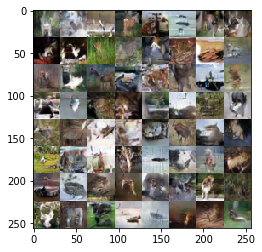

In [0]:
 
  #Compile the generator and discriminator
  test_noise = np.random.randn(64, 128)  
  generated_image = generator.predict(test_noise)
  generated_image = (generated_image + 1)/2
  
  #plot image
  for i in range(8):
      new = generated_image[i*8:i*8+8].reshape(32*8,32,3)
      if i!=0:
          old = np.concatenate((old,new),axis=1)
      else:
          old = new
  print('plot generated_image')
  plt.imshow(old)
  print('Generating FID please wait will take time as we are considering 10,000 images')
  print(generateFID())

**Train the discrminator and Generator**

In [23]:
test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)

Discriminator_real = []
Discriminator_fake = []
Discriminator_loss = []
Generator_loss = []

d_real_perepoch = []
d_fake_perepoch = []
d_loss_perepoch = []
g_loss_perepoch = []

FID = []
fid = 0
counter = 0
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)), width=20)
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            #Generate noise and predict discriminator
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            generated_image = generator.predict(noise)
            # print(generated_image.shape)
            
            #Caluculating and storing the lossess
            err_real = training_discriminator.train_on_batch(image_batch, real_y)
            err_fake = training_discriminator.train_on_batch(generated_image, fake_y)
            err_total = (err_real + err_fake)
            Discriminator_loss.append(err_total)
            Discriminator_real.append(err_real)
            Discriminator_fake.append(err_fake)
            
            
            
        #training  generator
        discriminator.trainable = False
        generator.trainable = True
        err_g = training_generator.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y)
        log_write(logs_loss, [err_real, err_fake, err_total, err_g])
        Generator_loss.append(err_g)
        counter +=1
        if(np.mod(counter, FID_AT) == 0):
            fid = generateFID()
            FID.append(fid)
            log_write(logs_loss, [FID])
            if epoch != 0 and epoch % model_save_interval == 0:
              save_models(generator, discriminator, training_discriminator, epoch)        
    print('\nepoch time: {}'.format(time()-start_time))
    print("fid: {}".format(fid))
    
    #Saving losses per Epoch
    d_real_perepoch.append(err_real)
    d_fake_perepoch.append(err_fake)
    d_loss_perepoch.append(err_total)
    g_loss_perepoch.append(err_g)

    
    print("d_real_loss:{} d_fake_loss:{} d_loss:{} g_loss:{}".format(d_real_perepoch, d_fake_perepoch, d_loss_perepoch, g_loss_perepoch))

    
    
    #Generate image
    generated_image = generator.predict(test_noise)
    generated_image = (generated_image + 1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(32*GENERATE_ROW_NUM,32,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave(SAVE_IMG_DIR + 'SN_epoch_{}.png'.format(epoch), old)

lossfile.close()


    

epoch 1 of 500
number of batches: 781
  0/781 [....................] - ETA: 0sWARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


780/781 [==================>.] - ETA: 0s
epoch time: 172.6858673095703
fid: 0
d_real_loss:[0.13365139] d_fake_loss:[0.05711007] d_loss:[0.19076146] g_loss:[6.573907]
plot generated_image
epoch 2 of 500
number of batches: 781
780/781 [==================>.] - ETA: 0s
epoch time: 384.49621772766113
fid: 47.30581898128553
d_real_loss:[0.13365139, 0.0074397195] d_fake_loss:[0.05711007, 0.07111325] d_loss:[0.19076146, 0.07855297] g_loss:[6.573907, 6.915378]
plot generated_image
epoch 3 of 500
number of batches: 781
780/781 [==================>.] - ETA: 0s
epoch time: 374.30656456947327
fid: 54.525539424725224
d_real_loss:[0.13365139, 0.0074397195, 0.06536681] d_fake_loss:[0.05711007, 0.07111325, 0.06535404] d_loss:[0.19076146, 0.

KeyboardInterrupt: ignored